In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.initializers import glorot_uniform
from keras import backend as K
import matplotlib.pyplot as plt
import os

In [2]:
train_data_dir = '/content/drive/MyDrive/Apziva/project4/images/training'
test_data_dir = '/content/drive/MyDrive/Apziva/project4/images/testing'
model_dir = '/content/drive/MyDrive/Apziva/project4/models/'

In [3]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

print('Properties of training data...')
train_dataset, validation_dataset = image_dataset_from_directory(train_data_dir,
                                                                 shuffle=True,
                                                                 validation_split = 0.2,
                                                                 subset = 'both',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 seed=42)
print('Properties of testing dataset...')
test_dataset = image_dataset_from_directory(test_data_dir,
                                            shuffle=False,
                                            image_size=IMG_SIZE,
                                            seed=42)

class_names = train_dataset.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

print(f'Class names: {class_names}')

Exploring the training dataset...
Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Using 478 files for validation.
Exploring the testing dataset...
Found 597 files belonging to 2 classes.
The class names are: ['flip', 'notflip']


#VGG16

In [5]:
tf.random.set_seed(42)

preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [6]:
input_shape = IMG_SIZE + (3,)
data_augmentation = tf.identity
base_model = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.2)(x)
outputs = tfl.Dense(1, activation='linear')(x)

vgg_model = tf.keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 1s 0us/step


In [7]:
vgg_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics = ['accuracy', f1_score])

In [8]:
initial_epochs = 3
history = vgg_model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs=initial_epochs)

Epoch 1/3
60/60 [==============================] - 641s 10s/step - loss: 1.7862 - accuracy: 0.5825 - f1_score: 0.5595 - val_loss: 0.7786 - val_accuracy: 0.6987 - val_f1_score: 0.6985
Epoch 2/3
60/60 [==============================] - 612s 10s/step - loss: 0.9270 - accuracy: 0.7085 - f1_score: 0.6963 - val_loss: 0.4429 - val_accuracy: 0.8159 - val_f1_score: 0.8198
Epoch 3/3
60/60 [==============================] - 488s 8s/step - loss: 0.6430 - accuracy: 0.7743 - f1_score: 0.7654 - val_loss: 0.3082 - val_accuracy: 0.8745 - val_f1_score: 0.8734


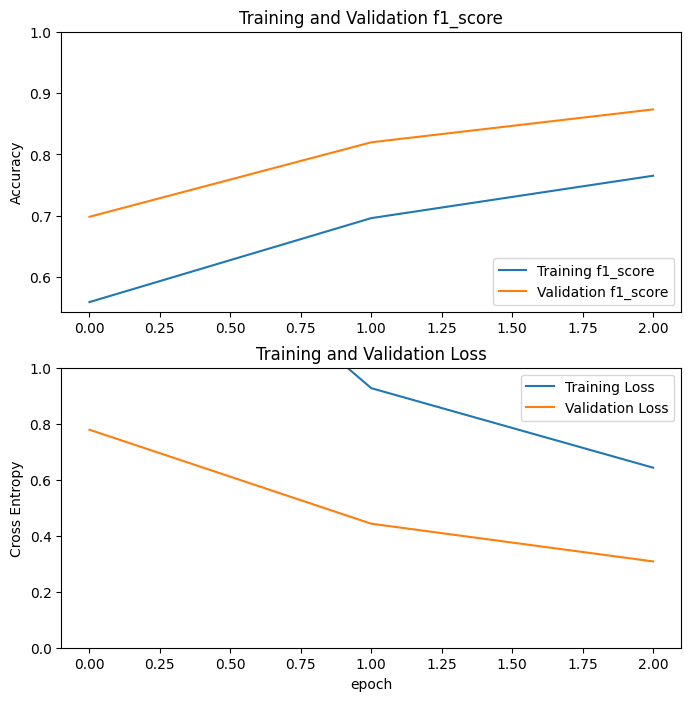

In [9]:
score = history.history['f1_score']
val_score = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [10]:
base_model = vgg_model.layers[4]
base_model.trainable = True
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 19


In [11]:
fine_tune_at = 15
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [12]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0001,
                                                             decay_steps = len(train_dataset),
                                                             decay_rate = 0.9,
                                                             staircase = False)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
metrics = ['accuracy', f1_score]

vgg_model.compile(loss=loss_function,
                  optimizer = optimizer,
                  metrics=metrics)

In [13]:
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = vgg_model.fit(train_dataset,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_dataset)

vgg_model.save_weights(model_dir+'VGG16')

Epoch 3/6
60/60 [==============================] - 622s 10s/step - loss: 0.4910 - accuracy: 0.8339 - f1_score: 0.8157 - val_loss: 0.0512 - val_accuracy: 0.9854 - val_f1_score: 0.9864
Epoch 4/6
60/60 [==============================] - 575s 10s/step - loss: 0.0497 - accuracy: 0.9812 - f1_score: 0.9812 - val_loss: 0.0220 - val_accuracy: 0.9979 - val_f1_score: 0.9986
Epoch 5/6
60/60 [==============================] - 610s 10s/step - loss: 0.0196 - accuracy: 0.9943 - f1_score: 0.9937 - val_loss: 0.0163 - val_accuracy: 0.9979 - val_f1_score: 0.9978
Epoch 6/6
60/60 [==============================] - 614s 10s/step - loss: 0.0094 - accuracy: 0.9969 - f1_score: 0.9968 - val_loss: 0.0150 - val_accuracy: 0.9958 - val_f1_score: 0.9957


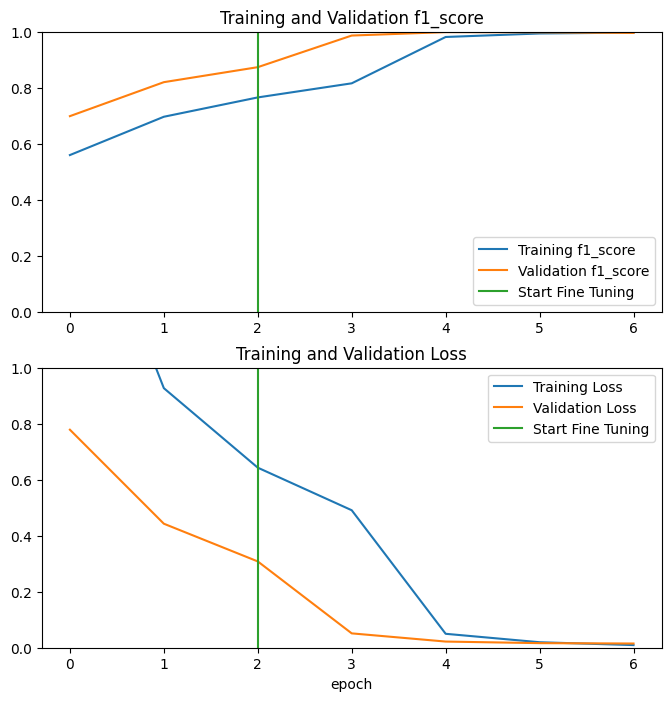

In [14]:
score += history_fine.history['f1_score']
val_score += history_fine.history['val_f1_score']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [15]:
print('Evaluating the model on the test set\n')
vgg_model.evaluate(test_dataset)
test_predictions = vgg_model.predict(test_dataset)

Evaluating the model on the test set

19/19 [==============================] - 124s 6s/step


#ResNet

In [16]:
tf.random.set_seed(42)

preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [17]:
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.2)(x)
outputs = tfl.Dense(1, activation='linear')(x)
resnet_model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 0s 0us/step


In [18]:
resnet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                       loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       metrics = ['accuracy', f1_score])
initial_epochs = 3
history = resnet_model.fit(train_dataset,
                             validation_data=validation_dataset,
                             epochs=initial_epochs)

Epoch 1/3
60/60 [==============================] - 190s 3s/step - loss: 0.6874 - accuracy: 0.6714 - f1_score: 0.6208 - val_loss: 0.3831 - val_accuracy: 0.8222 - val_f1_score: 0.8288
Epoch 2/3
60/60 [==============================] - 184s 3s/step - loss: 0.3648 - accuracy: 0.8312 - f1_score: 0.8187 - val_loss: 0.2585 - val_accuracy: 0.8849 - val_f1_score: 0.8852
Epoch 3/3
60/60 [==============================] - 182s 3s/step - loss: 0.3093 - accuracy: 0.8631 - f1_score: 0.8571 - val_loss: 0.2105 - val_accuracy: 0.9121 - val_f1_score: 0.9113


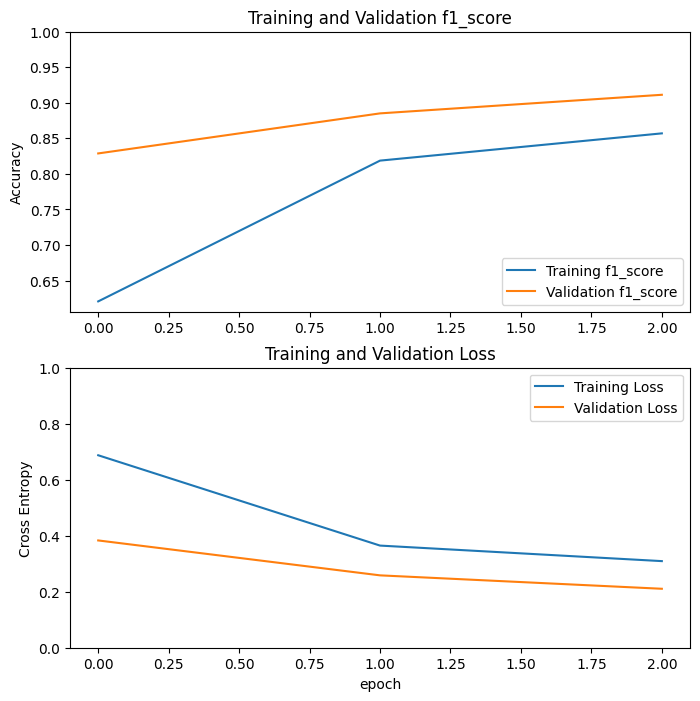

In [19]:
score = history.history['f1_score']
val_score = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [20]:
base_model = resnet_model.layers[4]
base_model.trainable = True
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 175


In [21]:
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [22]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0001,
                                                             decay_steps = len(train_dataset),
                                                             decay_rate = 0.9,
                                                             staircase = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
metrics = ['accuracy', f1_score]

resnet_model.compile(loss = loss_function,
                       optimizer = optimizer,
                       metrics = metrics)

In [26]:
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = resnet_model.fit(train_dataset,
                                  epochs=total_epochs,
                                  initial_epoch=history.epoch[-1],
                                  validation_data=validation_dataset)

resnet_model.save_weights(model_dir+'ResNet50')

Epoch 3/6
60/60 [==============================] - 336s 6s/step - loss: 0.2265 - accuracy: 0.8934 - f1_score: 0.8769 - val_loss: 0.1017 - val_accuracy: 0.9540 - val_f1_score: 0.9537
Epoch 4/6
60/60 [==============================] - 303s 5s/step - loss: 0.0562 - accuracy: 0.9807 - f1_score: 0.9805 - val_loss: 0.0615 - val_accuracy: 0.9791 - val_f1_score: 0.9798
Epoch 5/6
60/60 [==============================] - 301s 5s/step - loss: 0.0252 - accuracy: 0.9922 - f1_score: 0.9920 - val_loss: 0.0123 - val_accuracy: 0.9958 - val_f1_score: 0.9959
Epoch 6/6
60/60 [==============================] - 302s 5s/step - loss: 0.0082 - accuracy: 0.9990 - f1_score: 0.9989 - val_loss: 0.0102 - val_accuracy: 0.9979 - val_f1_score: 0.9978


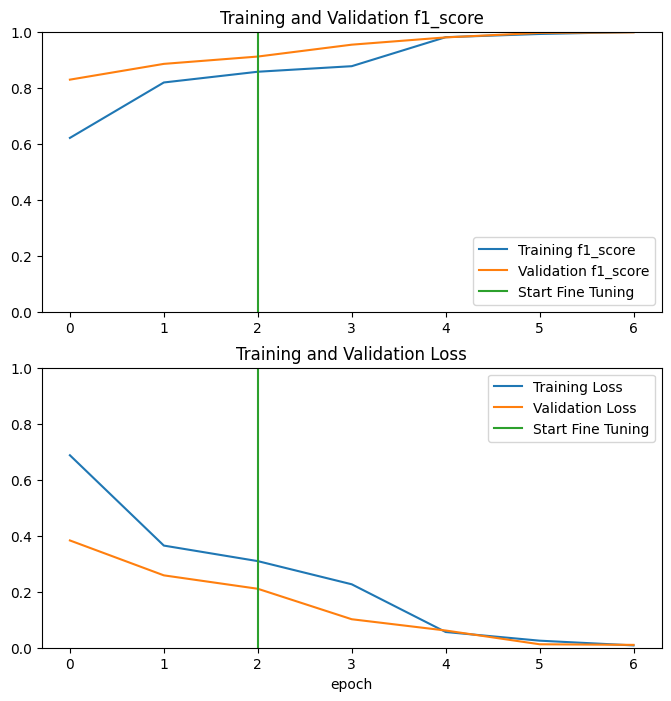

In [27]:
score += history_fine.history['f1_score']
val_score += history_fine.history['val_f1_score']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [29]:
print('Evaluating the model on the test set\n')
resnet_model.evaluate(test_dataset)
test_predictions = resnet_model.predict(test_dataset)

Evaluating the model on the test set

19/19 [==============================] - 44s 2s/step


#MobileNet

In [30]:
tf.random.set_seed(42)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [33]:
input_shape = IMG_SIZE + (3,)
data_augmentation = tf.identity
base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.2)(x)
outputs = tfl.Dense(1, activation = 'linear')(x)

mobilenet_model = tf.keras.Model(inputs, outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [34]:
mobilenet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
                          loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          metrics = ['accuracy', f1_score])

In [35]:
initial_epochs = 3
history = mobilenet_model.fit(train_dataset,
                                validation_data=validation_dataset,
                                epochs=initial_epochs)

Epoch 1/3
60/60 [==============================] - 58s 833ms/step - loss: 0.6727 - accuracy: 0.5831 - f1_score: 0.4638 - val_loss: 0.5144 - val_accuracy: 0.7008 - val_f1_score: 0.6188
Epoch 2/3
60/60 [==============================] - 58s 916ms/step - loss: 0.4876 - accuracy: 0.7299 - f1_score: 0.6883 - val_loss: 0.4241 - val_accuracy: 0.7720 - val_f1_score: 0.7300
Epoch 3/3
60/60 [==============================] - 64s 1s/step - loss: 0.4021 - accuracy: 0.7983 - f1_score: 0.7752 - val_loss: 0.3590 - val_accuracy: 0.8515 - val_f1_score: 0.8429


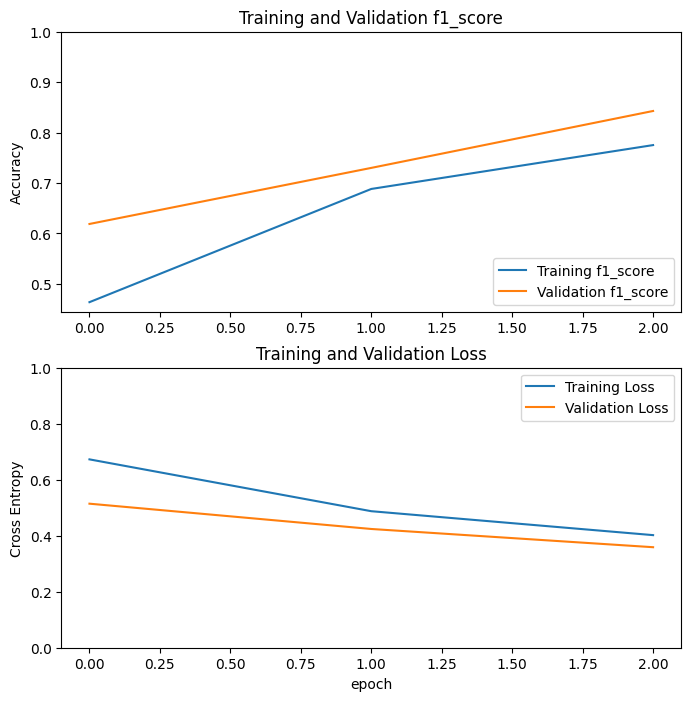

In [36]:
score = history.history['f1_score']
val_score = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [37]:
base_model = mobilenet_model.layers[4]
base_model.trainable = True
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 154


In [39]:
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [40]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.0001,
                                                             decay_steps = len(train_dataset),
                                                             decay_rate = 0.8,
                                                             staircase = False
                                                             )
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
metrics = ['accuracy', f1_score]

mobilenet_model.compile(loss=loss_function,
                          optimizer = optimizer,
                          metrics=metrics
                          )

In [41]:
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = mobilenet_model.fit(train_dataset,
                                     epochs=total_epochs,
                                     initial_epoch=history.epoch[-1],
                                     validation_data=validation_dataset
                                     )

mobilenet_model.save_weights(model_dir+'MobileNetV2')

Epoch 3/6
60/60 [==============================] - 79s 1s/step - loss: 0.2763 - accuracy: 0.8814 - f1_score: 0.8669 - val_loss: 0.0796 - val_accuracy: 0.9833 - val_f1_score: 0.9830
Epoch 4/6
60/60 [==============================] - 77s 1s/step - loss: 0.0702 - accuracy: 0.9728 - f1_score: 0.9724 - val_loss: 0.0247 - val_accuracy: 0.9958 - val_f1_score: 0.9957
Epoch 5/6
60/60 [==============================] - 65s 1s/step - loss: 0.0212 - accuracy: 0.9953 - f1_score: 0.9955 - val_loss: 0.0102 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 6/6
60/60 [==============================] - 74s 1s/step - loss: 0.0128 - accuracy: 0.9969 - f1_score: 0.9966 - val_loss: 0.0076 - val_accuracy: 0.9979 - val_f1_score: 0.9982


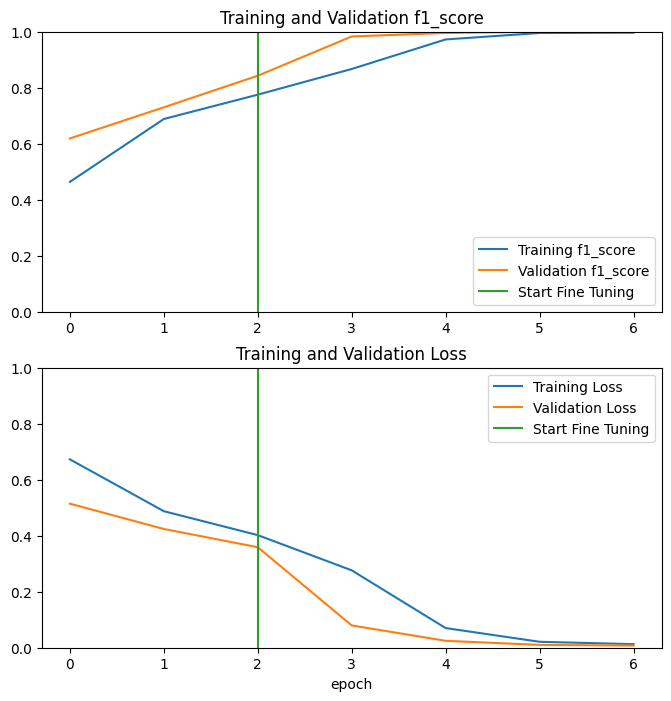

In [42]:
score += history_fine.history['f1_score']
val_score += history_fine.history['val_f1_score']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(score, label='Training f1_score')
plt.plot(val_score, label='Validation f1_score')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [43]:
print('Evaluating the model on the test set\n')
mobilenet_model.evaluate(test_dataset)
test_predictions = mobilenet_model.predict(test_dataset)

Evaluating the model on the test set

19/19 [==============================] - 15s 671ms/step
